<a href="https://colab.research.google.com/github/mein1728/kk/blob/main/face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [17]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [18]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [19]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg


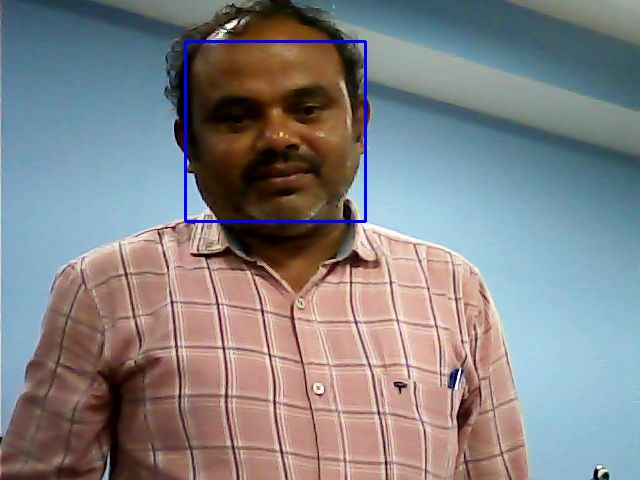

In [26]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [21]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [25]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray)
    # get face bounding box for overlay
    for (x,y,w,h) in faces:
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes
    

<IPython.core.display.Javascript object>

In [42]:
!pip  install weakref


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement weakref (from versions: none)
ERROR: No matching distribution found for weakref


In [ ]:
!pip install pyttsx3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
import threading
import time
import cv2
import imutils

# Set up the video capture device
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)

# Initialize the alarm variables
alarm = False
alarm_mode = False
alarm_counter = 0

# Define the alarm function
def beep_alarm():
    global alarm
    for _ in range(5):
        if not alarm_mode:
            break
        print("ALARM")
        # Replace the winsound.Beep() function with any other alarm sound function of your choice
        time.sleep(1)
    alarm = False

# Define the motion detection function
def detect_motion():
    global start_frame, alarm_counter, alarm_mode
    # Set up the initial frame for motion detection
    _, start_frame = cap.read()
    start_frame = imutils.resize(start_frame, width=500)
    start_frame = cv2.cvtColor(start_frame, cv2.COLOR_BGR2GRAY)
    start_frame = cv2.resize(start_frame, (21, 21), 0)
    while True:
        _, frame = cap.read()
        frame = imutils.resize(frame, width=500)
        if alarm_mode:
            frame_bw = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frame_bw = cv2.GaussianBlur(frame_bw, (5, 5), 0)
            difference = cv2.absdiff(frame_bw, start_frame)
            threshold = cv2.threshold(difference, 25, 255, cv2.THRESH_BINARY)[1]
            start_frame = frame_bw
            if threshold.sum() > 300:
                alarm_counter += 1000
            else:
                if alarm_counter > 0:
                    alarm_counter -= 1
            cv2.imshow("Cam", threshold)
        else:
            cv2.imshow("Cam", frame)

        if alarm_counter > 20:
            if not alarm:
                alarm = True
                threading.Thread(target=beep_alarm).start()

        key_pressed = cv2.waitKey(30)
        if key_pressed == ord("q"):
            alarm_mode = False
            break

# Define the alarm clock function
def set_alarm():
    global alarm_mode
    alarm_time = input("Enter alarm time in format HH:MM:SS - ")
    while True:
        current_time = time.strftime


In [49]:
import cv2
import pyttsx3
import threading

status_list=[None,None]

alarm_sound = pyttsx3.init()
voices = alarm_sound.getProperty('voices')
alarm_sound.setProperty('voice', voices[0].id)
alarm_sound.setProperty('rate', 150)

def voice_alarm(alarm_sound):
    alarm_sound.say("Object Detected")
    alarm_sound.runAndWait()


video=cv2.VideoCapture(0)
initial_frame = None

while True:
    check, frame = video.read()
    frame = cv2.flip(frame,1)
    status=0

    gray_frame=cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    gray_frame=cv2.GaussianBlur(gray_frame,(25,25),0)

    blur_frame = cv2.blur(gray_frame, (5,5))
    
    if initial_frame is None:
        initial_frame = blur_frame
        continue

    delta_frame=cv2.absdiff(initial_frame,blur_frame)
    threshold_frame=cv2.threshold(delta_frame,35,255, cv2.THRESH_BINARY)[1]

    (contours,_)=cv2.findContours(threshold_frame,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)


    for c in contours:
        if cv2.contourArea(c) < 5000:
            continue
        status=status + 1
        (x, y, w, h)=cv2.boundingRect(c)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0,255,0), 1)
    status_list.append(status)

    if status_list[-1]>= 1 and status_list[-2]==0:
        alarm = threading.Thread(target=voice_alarm, args=(alarm_sound,))
        alarm.start()

    cv2.imshow('motion detector', frame)
    key = cv2.waitKey(1)
    if key == ord('q'):
        break

alarm_sound.stop()
video.release()
cv2.destroyAllWindows()

OSError: ignored

In [50]:
!pip install ffpyplayer


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 5.4 MB/s eta 0:00:00


In [ ]:
dir()

In [51]:
import cv2
import numpy as np
from ffpyplayer.player import MediaPlayer
import time

cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
_, bg = cap.read()
bg = cv2.cvtColor(bg, cv2.COLOR_BGR2GRAY)
bg = cv2.GaussianBlur(bg, (21, 21), 0)

player = MediaPlayer("alert.wav")

while True:
    ret, frame = cap.read()
    if not ret:
        break
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (21, 21), 0)
    diff = cv2.absdiff(bg, gray)
    thresh = cv2.threshold(diff, 25, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.dilate(thresh, None, iterations=2)
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        if cv2.contourArea(contour) < 1000:
            continue
        (x, y, w, h) = cv2.boundingRect(contour)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        player.play()
    cv2.imshow("Camera Feed", frame)
    key = cv2.waitKey(1)
    if key == ord('q'):
        break
player.close_player()
cv2.destroyAllWindows()
cap.release()


error: ignored

In [1]:
import cv2
import numpy as np
import time

cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)

_, bg = cap.read()
if bg is None:
    print("Error: failed to capture frame from camera")
    cap.release()
    exit()

bg = cv2.cvtColor(bg, cv2.COLOR_BGR2GRAY)
bg = cv2.GaussianBlur(bg, (21, 21), 0)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (21, 21), 0)
    diff = cv2.absdiff(bg, gray)
    thresh = cv2.threshold(diff, 25, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.dilate(thresh, None, iterations=2)
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        if cv2.contourArea(contour) < 1000:
            continue
        (x, y, w, h) = cv2.boundingRect(contour)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        winsound.PlaySound("alert.wav", winsound.SND_ASYNC)
    cv2.imshow("Camera Feed", frame)
    key = cv2.waitKey(1)
    if key == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Error: failed to capture frame from camera


error: ignored

In [ ]:
import cv2
import numpy as np
import winsound

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (21, 21), 0)

    if 'background' not in locals():
        background = gray
        continue

    diff = cv2.absdiff(background, gray)
    _, thresh = cv2.threshold(diff, 25, 255, cv2.THRESH_BINARY)
    thresh = cv2.dilate(thresh, None, iterations=2)

    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        if cv2.contourArea(contour) < 5000:
            continue
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        winsound.PlaySound('alert.wav', winsound.SND_ASYNC)

    cv2.imshow('frame', frame)
    cv2.imshow('diff', thresh)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [ ]:
import numpy as np
import cv2
import time


# creating the videocapture object
# and reading from the input file
# Change it to 0 if reading from webcam

cap = cv2.VideoCapture('vid.mp4')

# used to record the time when we processed last frame
prev_frame_time = 0

# used to record the time at which we processed current frame
new_frame_time = 0

# Reading the video file until finished
while(cap.isOpened()):

	# Capture frame-by-frame

	ret, frame = cap.read()

	# if video finished or no Video Input
	if not ret:
		break

	# Our operations on the frame come here
	gray = frame

	# resizing the frame size according to our need
	gray = cv2.resize(gray, (500, 300))

	# font which we will be using to display FPS
	font = cv2.FONT_HERSHEY_SIMPLEX
	# time when we finish processing for this frame
	new_frame_time = time.time()

	# Calculating the fps

	# fps will be number of frame processed in given time frame
	# since their will be most of time error of 0.001 second
	# we will be subtracting it to get more accurate result
	fps = 1/(new_frame_time-prev_frame_time)
	prev_frame_time = new_frame_time

	# converting the fps into integer
	fps = int(fps)

	# converting the fps to string so that we can display it on frame
	# by using putText function
	fps = str(fps)

	# putting the FPS count on the frame
	cv2.putText(gray, fps, (7, 70), font, 3, (100, 255, 0), 3, cv2.LINE_AA)

	# displaying the frame with fps
	cv2.imshow('frame', gray)

	# press 'Q' if you want to exit
	if cv2.waitKey(1) & 0xFF == ord('q'):
		break

# When everything done, release the capture
cap.release()
# Destroy the all windows now
cv2.destroyAllWindows()


In [ ]:
import cv2

# Opens the inbuilt camera of laptop to capture video.
cap = cv2.VideoCapture("path/to/video.mp4")

success, image = cap.read()
frame_count = 0
while success:
	cv2.imwrite(f"extracted_images/frame_{frame_count}.jpg", image)
	success, image = cap.read()
	frame_count += 1

cap.release()


In [ ]:
dir(pyttsx3)

['Engine',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_activeEngines',
 'driver',
 'drivers',
 'engine',
 'init',
 'six',
 'speak',
 'voice',
 'weakref']

In [ ]:
help(pyttsx3)

Help on package pyttsx3:

NAME
    pyttsx3

PACKAGE CONTENTS
    driver
    drivers (package)
    engine
    six
    voice

FUNCTIONS
    init(driverName=None, debug=False)
        Constructs a new TTS engine instance or reuses the existing instance for
        the driver name.
        
        @param driverName: Name of the platform specific driver to use. If
            None, selects the default driver for the operating system.
        @type: str
        @param debug: Debugging output enabled or not
        @type debug: bool
        @return: Engine instance
        @rtype: L{engine.Engine}
    
    speak(text)

FILE
    /usr/local/lib/python3.9/dist-packages/pyttsx3/__init__.py




In [ ]:
!pip install winsound


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement winsound (from versions: none)
ERROR: No matching distribution found for winsound
